In [215]:
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal
from jax import value_and_grad, grad
from jax.random import PRNGKey, normal, split, uniform
from jax.lax import cond, fori_loop
from jax import jit
from functools import partial

In [216]:
# First goal: Sample from an MVN
@jit
def log_posterior(x):
    
    return multivariate_normal.logpdf(x, jnp.zeros_like(x), jnp.array([[1., 0.9],
                                                                       [0.9, 1.]]))

grad_fun = jit(grad(log_posterior))

In [217]:
theta_dim = 2

In [218]:
M = jnp.eye(theta_dim)

In [219]:
@jit
def draw_phi(key, M):
    
    key, subkey = split(key)
    
    M_chol = jnp.linalg.cholesky(M)
    
    draw = normal(subkey, (M.shape[0],))
    phi = M_chol @ draw
    
    return key, phi


@partial(jit, static_argnums=4)
def leapfrog(theta, phi, M, eps, grad_fun):
    
    cur_grad = grad_fun(theta)
    
    phi_star = phi + 0.5 * eps * cur_grad
    theta = theta + eps * jnp.linalg.solve(M, phi)
    cur_grad = grad_fun(theta)
    phi_star = phi_star + 0.5 * eps * cur_grad
    
    return theta, phi_star


@partial(jit, static_argnums=5)
def metropolis_hastings(theta, theta_star, phi, phi_star, key, log_posterior):
    
    log_prob_phi_star = multivariate_normal.logpdf(phi_star, jnp.zeros_like(theta), M)
    log_prob_phi = multivariate_normal.logpdf(phi, jnp.zeros_like(theta), M)

    log_prob_theta = log_posterior(theta)
    log_prob_theta_star = log_posterior(theta_star)

    log_numerator = log_prob_theta_star + log_prob_phi_star
    log_denominator = log_prob_theta + log_prob_phi

    log_accept_prob = log_numerator - log_denominator

    accept_prob = jnp.exp(log_accept_prob)

    key, subkey = split(key)

    rand_draw = uniform(subkey)

    new_theta = cond(rand_draw < accept_prob, lambda _: theta_star, lambda _: theta, theta)
    
    return key, new_theta, accept_prob

In [220]:
key = PRNGKey(2)

In [221]:
@partial(jit, static_argnums=2)
def body_fun_leapfrog(i, val, grad_fun):
    
    theta_star, phi_star = leapfrog(
        val['theta'], val['phi'], val['M'], val['eps'], grad_fun)
    
    val['theta'] = theta_star
    val['phi'] = phi_star
    
    return val

In [222]:
@partial(jit, static_argnums=5)
def iterate_leapfrogs(theta, phi, eps, M, L, grad_fun):
    
    init_val = {
        'theta': theta,
        'phi': phi,
        'eps': eps,
        'M': M
    }
    
    to_iterate = lambda i, val: body_fun_leapfrog(i, val, grad_fun)
    
    final_res = fori_loop(0, L, to_iterate, init_val)
    
    return final_res['theta'], final_res['phi']

In [223]:
L = 32
n_samples = 4000
eps = 0.01


In [224]:
from jax.ops import index_update

In [225]:
@partial(jit, static_argnums=(2, 3))
def body_fun_sampling(i, val, grad_fun, log_posterior):
    
    key, phi = draw_phi(val['key'], val['M'])

    theta_star, phi_star = iterate_leapfrogs(val['theta'], phi, val['eps'], val['M'], val['L'], grad_fun)

    key, theta, accept_prob = metropolis_hastings(val['theta'], theta_star, phi, phi_star, key, log_posterior)
    
    val['samples'] = index_update(val['samples'], i, theta)
    val['theta'] = theta
    val['key'] = key
    
    return val

In [226]:
def draw_samples(theta_dim, eps, M, L, key, n_samples, grad_fun, log_posterior):
        
    theta = jnp.zeros(theta_dim)
    
    init_val = {
        'theta': theta,
        'eps': eps,
        'M': M,
        'key': key,
        'L': L,
        'samples': jnp.zeros((n_samples, theta_dim))
    }
    
    to_iterate = lambda i, val: body_fun_sampling(i, val, grad_fun, log_posterior)
    
    final_res = fori_loop(0, n_samples, to_iterate, init_val)
    
    return final_res

In [227]:
final_result = draw_samples(theta_dim, eps, M, L, key, n_samples, grad_fun, log_posterior)

In [228]:
import matplotlib.pyplot as plt
%matplotlib inline

In [229]:
final_result['samples']

DeviceArray([[-0.06165959, -0.09449932],
             [ 0.13615555,  0.19343507],
             [-0.07628115, -0.13415541],
             ...,
             [-1.0499508 , -1.0812292 ],
             [-1.0499508 , -1.0812292 ],
             [-0.9213367 , -0.8948988 ]], dtype=float32)

In [230]:
# Sample from the true posterior
from numpy.random import multivariate_normal as mvn_np

true_draws = mvn_np(jnp.zeros(theta_dim), jnp.array([[1., 0.9],
                                        [0.9, 1.]]), size=1000)

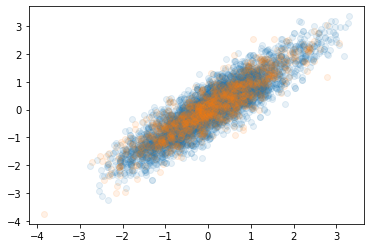

In [231]:
plt.scatter(final_result['samples'][:, 0], final_result['samples'][:, 1], alpha=0.1)
plt.scatter(true_draws[:, 0], true_draws[:, 1], alpha=0.1)

In [232]:
import seaborn as sns

In [233]:
final_result['samples'].mean(axis=0)

DeviceArray([0.06503534, 0.04898191], dtype=float32)

In [234]:
final_result['samples'].std(axis=0)

DeviceArray([0.99619514, 1.011081  ], dtype=float32)

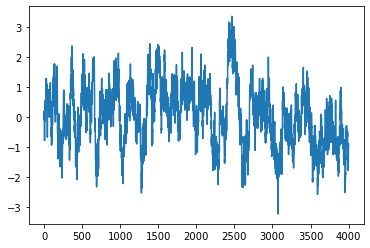

In [235]:
plt.plot(final_result['samples'][:, 2])